# WRMF Search Space Reduction

**Objectives:**
1. Split the dataframe into a train and test set *on playlists* before the implicit ratings matrix is calculated
2. Leave $k$ songs out of $m$ playlists in the training set. Calculate how many songs have to be recommended before the above model achieves a high enough recall/hit rate for the left out songs for these incomplete playlists.
3. Perform a grid search to optimise all hyperparameters.
4. Recalculate model's ability to reduce down the song search space using the optimised hyperparameters.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

import implicit
from tqdm.notebook import tqdm, trange

from sklearn.model_selection import train_test_split

import sys
sys.path.append("..")

from collections import defaultdict
from importlib import reload

import pickle

from joblib import delayed, Parallel

import seaborn as sns
sns.set()

In [2]:
import df_utils
import mf_utils

In [3]:
df = pd.read_csv("cleaned_data_0.2.csv", index_col=[0])
songs_df = pd.read_csv("songs_DF.csv", index_col=[0])

/Users/vedantvarshney/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Train-test split

In [203]:
train_df, test_df = train_test_split(df, test_size=0.1)

In [204]:
train_df.head()

,source,user_id,track_name,artist_name,playlist_id,tags,playlist_name,spotify_id,album,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
42560,vagalume,luanabatalha%0A,Breakaway,Avril Lavigne,5286837,"pop,rock,rock alternativo",Românticas,4PFAm88FBkY7IFtvCaGctZ,Breakaway,62.0,0.268,0.716,-4.151,0.0337,0.0421,0.000010,0.1080,0.393,160.008
322468,vagalume,helotwardowski%0A,11 Vidas,Lucas Lucco,5332827,"pop,pop/rock,dance",Neverland,57n605a9nDDzchHanKhP0u,O Destino (Bonus Track Version),43.0,0.624,0.622,-5.780,0.0300,0.8040,0.000000,0.1550,0.457,140.021
209536,vagalume,rafael262%0A,Chora Viola / Caminheiro / Ladrão de Mulher / ...,Jorge e Mateus,5157622,"rock,hard rock,sertanejo",Moda de viola,5HeKtNkRSyNPR4HO1N4a0E,Jorge & Mateus Ao Vivo Em Goiânia (Ao Vivo Em ...,51.0,0.512,0.879,-4.636,0.0639,0.2210,0.000000,0.3280,0.777,118.866
233555,vagalume,fabricio_alex_%0A,Pergunte Pro Seu Coração,Roberto Carlos,5474873,"mpb,romântico,sertanejo",roberto carlos,5bQklaqByFBadQbc3whCsj,Box Roberto Carlos Anos 90,18.0,0.659,0.620,-8.156,0.0269,0.2170,0.000014,0.0763,0.536,88.246
184704,vagalume,levisoares%0A,I Won't Apologize,Selena Gomez,5554902,"pop,dance,sertanejo",SELENA GOMES,2Cmjtu8ZXmHq2EsehUeCx3,Kiss & Tell,40.0,0.558,0.853,-3.827,0.0370,0.0240,0.000000,0.1050,0.795,145.897


Although WRMF will not use the order of the songs in a playlist, it would be good practice to resort the order now for use later.

In [205]:
train_df.sort_index(inplace=True)
train_df.head()

/Users/vedantvarshney/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,source,user_id,track_name,artist_name,playlist_id,tags,playlist_name,spotify_id,album,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,vagalume,sitevagalume,Eraser,Ed Sheeran,6736120,"pop,pop/rock,rock",Ed Sheeran - Divide,7oolFzHipTMg2nL7shhdz2,÷ (Deluxe),64.0,0.640,0.812,-5.647,0.0834,0.0860,0.000000,0.0509,0.914,86.013
1,vagalume,sitevagalume,Castle On The Hill,Ed Sheeran,6736120,"pop,pop/rock,rock",Ed Sheeran - Divide,6PCUP3dWmTjcTtXY02oFdT,÷ (Deluxe),78.0,0.461,0.834,-4.868,0.0989,0.0232,0.000011,0.1400,0.471,135.007
2,vagalume,sitevagalume,Dive,Ed Sheeran,6736120,"pop,pop/rock,rock",Ed Sheeran - Divide,51ChrwmUPDJvedPQnIU8Ls,÷ (Deluxe),75.0,0.761,0.386,-6.158,0.0399,0.3550,0.000000,0.0953,0.526,134.943
3,vagalume,sitevagalume,Shape Of You,Ed Sheeran,6736120,"pop,pop/rock,rock",Ed Sheeran - Divide,7qiZfU4dY1lWllzX7mPBI3,÷ (Deluxe),85.0,0.825,0.652,-3.183,0.0802,0.5810,0.000000,0.0931,0.931,95.977
4,vagalume,sitevagalume,Perfect,Ed Sheeran,6736120,"pop,pop/rock,rock",Ed Sheeran - Divide,0tgVpDi06FyKpA1z0VMD4v,÷ (Deluxe),86.0,0.599,0.448,-6.312,0.0232,0.1630,0.000000,0.1060,0.168,95.050


In [206]:
test_df.sort_index(inplace=True)
test_df.head()

/Users/vedantvarshney/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,source,user_id,track_name,artist_name,playlist_id,tags,playlist_name,spotify_id,album,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
6,vagalume,sitevagalume,Happier,Ed Sheeran,6736120,"pop,pop/rock,rock",Ed Sheeran - Divide,2RttW7RAu5nOAfq6YFvApB,÷ (Deluxe),81.0,0.522,0.385,-7.355,0.0288,0.53600,0.000000,0.1350,0.236,89.792
9,vagalume,sitevagalume,How Would You Feel (Paean),Ed Sheeran,6736120,"pop,pop/rock,rock",Ed Sheeran - Divide,6PJ8FF6UR8FZXfEvpHkIVN,÷ (Deluxe),69.0,0.617,0.439,-5.630,0.0269,0.42400,0.000000,0.1270,0.242,139.979
17,vagalume,sitevagalume,Hotline Bling,Drake,6123235,"pop,pop/rock,rock",Fugir do Carnaval Pop 2016,0wwPcA6wtMf6HUMpIRdeP7,Views,77.0,0.891,0.625,-7.861,0.0558,0.00261,0.000176,0.0504,0.548,134.967
31,vagalume,sitevagalume,Freedom,Pitbull,6123235,"pop,pop/rock,rock",Fugir do Carnaval Pop 2016,1StLlgkTm6s0LGRyAap9SP,Climate Change,50.0,0.701,0.931,-4.954,0.1190,0.09490,0.000000,0.1260,0.803,118.034
44,vagalume,sitevagalume,"Bang My Head (Feat. Sia, Fetty Wap (Remix)",David Guetta,6123243,"pop,pop/rock,rock",Fugir Carnaval Eletrônico 2016,440LuUlgdK3j9Uj8Q9L3Yj,Bang My Head (feat. Sia & Fetty Wap),33.0,0.733,0.675,-7.008,0.0647,0.14400,0.186000,0.1000,0.530,122.011


In [207]:
train_df.shape

(504522, 19)

In [208]:
test_df.shape

(56058, 19)

An adaptation of code from 'Exploring WRMF' notebook:

In [209]:
def df_to_sparse(df, all_songs):
    """
    Converts a dataframe to a sparse implicit ratings matrix.
    
    Arguments:
        - df - dataframe to convert to a sparse matrix
        - all_songs - list of all songs in the search space
        - withold_dict - a dictionary whose keys are playlist IDs and whose values are a list of songs which should be
        excluded from that playlist when calculating the implicit ratings matrix.
        
    Returns:
        - ratings_matrix - implicit ratings matrix in CSR format
    """
    # Create hashmap of the list of unique songs for fast index lookup
    # np.where etc will unnecessarily search the entire array and thus will not scale well.
    song_to_indx = {song: i for (i, song) in enumerate(all_songs)}
    
    # Mapping each song in the original DF to the index in the unique songs list
    song_indxs = df.spotify_id.apply(lambda id_: song_to_indx[id_]).values

    # Same for list of unique playlists
    playlist_to_indx = {playlist: i for (i, playlist) in enumerate(df.playlist_id.unique())}
    
    # Mapping each playlist in the original DF to the index in the unique playlists list
    playlist_indxs = df.playlist_id.apply(lambda id_: playlist_to_indx[id_]).values
    
    data = np.ones(df.shape[0])
    
    assert data.shape == song_indxs.shape == playlist_indxs.shape
    
    # Although matrix only contains int, cast as float for safety in future calculations
    # row indx = song indx
    # column indx = playlist indx
    ratings_matrix = sp.sparse.csr_matrix((data, (song_indxs, playlist_indxs)), dtype=np.float64)
    
    return ratings_matrix

In [210]:
def withold_songs(df, withold_split=(0.2,0.2)):
    """
    Removes a certain proportion of songs from a certain proportion of playlists in DF.
    
    Arguments:
        - df - standard cleaned_data DF
        - withold_split - tuple. First value = fraction of playlists to split.
        Second value = fraction of songs to remove from said playlists.
        
    Returns:
        - df with songs excluded
        - pd Series wrapping a dictionary of playlist and num_songs excluded.
        key = playlist; value = list of spotify IDs excluded.
        
    Note - the withold split is the target split; the exact split will vary slightly.
    This is to avoid splits creating empty playlists.
    """
    
#     Songs in each playlist
    playlist_vc = pd.value_counts(df.playlist_id)

#     Number of songs potentially excluded from each playlist
    split = playlist_vc.apply(lambda vc: round(vc*withold_split[1]))

#     Filter out playlists with a 0 split and which leave no songs in remaining playlist
    split = split[(split>0) & (playlist_vc>split)]
    
#     Sample valid playlists
    split = split.sample(frac=withold_split[0])
    
    indxs_to_drop = []
    
#     Dictionary for storing spotify IDs of songs excluded from each playlist
    excluded = defaultdict(list)
    
    for playlist_id, num_songs_excl in split.items():
        temp_excl_df = df[df.playlist_id==playlist_id].sample(num_songs_excl)
        
        excluded[playlist_id] += [row.spotify_id for _, row in temp_excl_df.iterrows()]
            
        indxs_to_drop += list(temp_excl_df.index.values)
        
    return df.drop(indxs_to_drop, axis=0), pd.Series(excluded)

In [211]:
split_train_df, excl = withold_songs(train_df)

In [212]:
train_df.shape

(504522, 19)

In [213]:
split_train_df.shape

(483197, 19)

In [214]:
pd.Series(excl)

6081816    [5uQxF5Bc8ekosDiOu9CENO, 4M3Ehwf8MBJAkxrcrhIE1...
5583789    [0u2P5u6lvoDfwTYjAADbn4, 5h8tTI1Z5TrWrrPL2HP0Y...
5145621    [213x4gsFDm04hSqIUkg88w, 3ZffCQKLFLUvYM59XKLbV...
5135555     [0rImThhPOV8wtgeyltD6no, 1QjC2KRzi0Nm3L4AAREwnY]
4906726    [1vkiIBhTNtCZhN4ZEYCgYI, 2bzoC7BAarN1ZmFHs8Dhf...
                                 ...                        
5374724                             [4TVuirwgzxe9fWRBoWtPpq]
5447216    [6abvu3x6fUlOniPRF8WCII, 6ltdafHEeNZ5C5AD4opmc...
27004       [3VTNVsTTu05dmTsVFrmGpK, 64MISVB9IIchhOKmWHftoz]
5056005    [7MXlTgQeo3IVlMpLnZuhxc, 0xIHLNAb0wPeQBu9C25bk...
5111799    [3gVkvfZ4rCmZ7oxjAWk1n9, 3ce7k1L4EkZppZPz1EJWT...
Length: 1958, dtype: object

In [215]:
train_df.shape[0] - split_train_df.shape[0]

21325

ModeResult(mode=array([1]), count=array([383]))


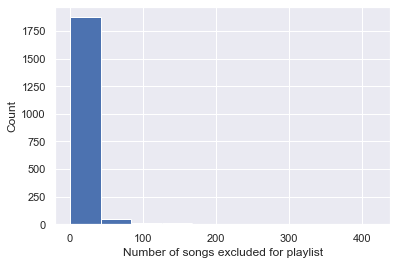

In [216]:
modal_songs_excl = sp.stats.mode(excl.apply(lambda x: len(x)))
print(modal_songs_excl)

plt.xlabel("Number of songs excluded for playlist")
plt.ylabel("Count")
excl.apply(lambda x: len(x)).hist()
plt.show()

In [217]:
split_train_df.to_csv("Split_Train_DF.csv")
pickle.dump(excl, open("Excluded_Songs_Series", "wb"))

In [218]:
train_df.to_csv("Train_DF.csv")
test_df.to_csv("Test_DF.csv")

## Creating ratings matrix

In [219]:
split_train_df = pd.read_csv("Split_Train_DF.csv", index_col=[0])

excl = pickle.load(open("Excluded_Songs_Series", "rb"))

In [220]:
split_train_df

,source,user_id,track_name,artist_name,playlist_id,tags,playlist_name,spotify_id,album,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,vagalume,sitevagalume,Eraser,Ed Sheeran,6736120,"pop,pop/rock,rock",Ed Sheeran - Divide,7oolFzHipTMg2nL7shhdz2,÷ (Deluxe),64.0,0.640,0.812,-5.647,0.0834,0.086000,0.000000,0.0509,0.914,86.013
1,vagalume,sitevagalume,Castle On The Hill,Ed Sheeran,6736120,"pop,pop/rock,rock",Ed Sheeran - Divide,6PCUP3dWmTjcTtXY02oFdT,÷ (Deluxe),78.0,0.461,0.834,-4.868,0.0989,0.023200,0.000011,0.1400,0.471,135.007
2,vagalume,sitevagalume,Dive,Ed Sheeran,6736120,"pop,pop/rock,rock",Ed Sheeran - Divide,51ChrwmUPDJvedPQnIU8Ls,÷ (Deluxe),75.0,0.761,0.386,-6.158,0.0399,0.355000,0.000000,0.0953,0.526,134.943
3,vagalume,sitevagalume,Shape Of You,Ed Sheeran,6736120,"pop,pop/rock,rock",Ed Sheeran - Divide,7qiZfU4dY1lWllzX7mPBI3,÷ (Deluxe),85.0,0.825,0.652,-3.183,0.0802,0.581000,0.000000,0.0931,0.931,95.977
4,vagalume,sitevagalume,Perfect,Ed Sheeran,6736120,"pop,pop/rock,rock",Ed Sheeran - Divide,0tgVpDi06FyKpA1z0VMD4v,÷ (Deluxe),86.0,0.599,0.448,-6.312,0.0232,0.163000,0.000000,0.1060,0.168,95.050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560575,8tracks,11027.0,Instant Karma,John Lennon,10532,"indie rock,unknown, alternative & punk",scascio,2E9wKgL8NN7Tvydqcjoh7v,Gimme Some Truth,53.0,0.624,0.931,-9.988,0.1160,0.000899,0.001490,0.0631,0.140,119.887
560576,8tracks,11027.0,This Must Be the Place (Naive Melody),Talking Heads,10532,"indie rock,unknown, alternative & punk",scascio,6aBUnkXuCEQQHAlTokv9or,Speaking in Tongues (Deluxe Version),71.0,0.942,0.641,-10.150,0.0333,0.331000,0.179000,0.0280,0.966,114.443
560577,8tracks,11027.0,Rock & Roll (Full-Length Version),The Velvet Underground,10532,"indie rock,unknown, alternative & punk",scascio,1o6DclZHw0HomxXEQR1ijX,Loaded: Re-Loaded 45th Anniversary Edition,62.0,0.494,0.735,-8.347,0.0345,0.004010,0.000003,0.5440,0.742,132.526
560578,8tracks,11027.0,So. Central Rain (I'm Sorry),R.E.M.,10532,"indie rock,unknown, alternative & punk",scascio,3AdyPM9rfgfPxoWS4tKh2O,Live At The Olympia,38.0,0.339,0.950,-4.797,0.0556,0.000804,0.000034,0.9700,0.460,142.148


In [221]:
split_train_ratings_matrix = mf_utils.df_to_sparse(split_train_df, all_songs=df.spotify_id.unique())

In [222]:
split_train_ratings_matrix

<105152x10531 sparse matrix of type '<class 'numpy.float64'>'
	with 479651 stored elements in Compressed Sparse Row format>

## Fitting ratings matrix

In [223]:
model = implicit.als.AlternatingLeastSquares(factors=150)

# items_users matrix in this case is the songs_playlist matrix
model.fit(split_train_ratings_matrix)

### Example recommendations

In [224]:
sample_playlist_indx = 10

recommendations = model.recommend(sample_playlist_indx, split_train_ratings_matrix.T)

In [225]:
mf_utils.inspect_recommendations(sample_playlist_indx, recommendations, split_train_df, songs_df)

Liked Tracks:
                                          track_name  \
spotify_id                                             
7DD7eSuYSC5xk2ArU62esN                         Help!   
1Ud6moTC0KyXMq1Oxfien0        Sympathy For The Devil   
3qiyyUfYe7CRYLucrPmulD                  Baba O'Riley   
7aE5WXu5sFeNRh3Z05wwu4            Wish You Were Here   
4u7EnebtmKWzUH433cf5Qv             Bohemian Rhapsody   
5CQ30WqJwcep0pYcV4AMNc            Stairway To Heaven   
5uvosCdMlFdTXhoazkTI5R                 Light My Fire   
6KTv0Z8BmVqM7DPxbGzpVC        Rock And Roll All Nite   
64Ny7djQ6rNJspquof2KoX                     Hound Dog   
2QfiRTz5Yc8DdShCxG1tB2               Johnny B. Goode   
5UvE5QlINnvEc7aFO14DVL      Great    Balls  Of  Fire   
0NWPxcsf5vdjdiFUI8NgkP                       Hey Joe   
63OFKbMaZSDZ4wtesuuq6f               Born To Be Wild   
6gJdDnF2TzfA1WPMXuCa3x                    Proud Mary   
3G7tRC24Uh09Hmp1KZ7LQ2                I'm A Believer   
08mG3Y1vljYA6bvDt4Wqkj            

## TODO
1. Calculate hit rate for top 20k songs for playlists which were split
2. Optimise hyperparameters
3. See how much search space can be reduced?

In [11]:
# CANNOT use songs_df here as order is different
indx_to_song = mf_utils.indx_mapping(df.spotify_id.unique())
indx_to_playlist = mf_utils.indx_mapping(split_train_df.playlist_id.unique())

song_to_indx = mf_utils.indx_mapping(df.spotify_id.unique(), indx_to_item=False)
playlist_to_indx = mf_utils.indx_mapping(split_train_df.playlist_id.unique(), indx_to_item=False)

In [227]:
def hit_rate(recommendations, excluded_songs):
    """
    Returns the hit rate (correct recommendations/number of songs excluded)
    
    Arguments:
        - recommendations - recs for a single playlist as returned by implicit
        - excluded_songs - Spotify IDs excluded from that playlist
    """
    recs_spotifyids = list(mf_utils.recs_to_spotifyids(recommendations, indx_to_song).keys())
    num_hits = len(set(recs_spotifyids).intersection(set(excluded_songs)))
    
    return num_hits/len(excluded_songs)

**Hit rate for an example playlist:**

In [246]:
sample_playlist = excl.sample(1).index[0]

In [247]:
recommendations = model.recommend(playlist_to_indx[sample_playlist], split_train_ratings_matrix.T, N=20000)

hit_rate(recommendations, excl[sample_playlist])

1.0

**Calculating hit rate for all 'split' playlists:**

In [248]:
hit_rates = []

for playlist_id, songs in tqdm(excl.items(), total=len(excl)):
    recs = model.recommend(playlist_to_indx[playlist_id], split_train_ratings_matrix.T, N=20000)
    hit_rates.append(hit_rate(recs, excl[playlist_id]))

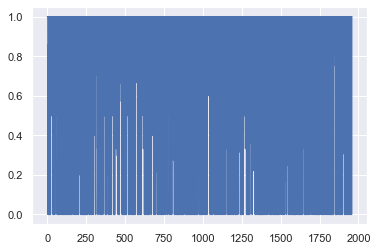

In [249]:
hit_rates = np.asarray(hit_rates)
plt.plot(hit_rates)

In [250]:
sort_indxs = np.argsort(hit_rates)

playlist_mask = df.playlist_id.isin(excl.index.values)

In [251]:
playlist_lengths = pd.value_counts(split_train_df.playlist_id[playlist_mask])

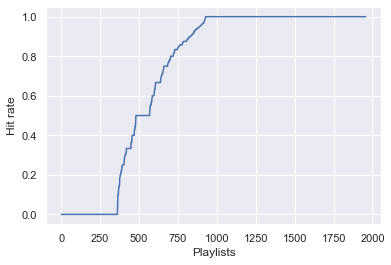

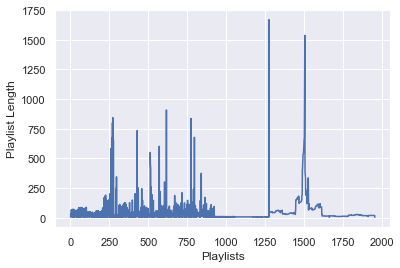

In [252]:
plt.xlabel("Playlists")
plt.ylabel("Hit rate")
plt.plot(hit_rates[sort_indxs], label="hit rate")
plt.show()

plt.xlabel("Playlists")
plt.ylabel("Playlist Length")
plt.plot(playlist_lengths.values[sort_indxs], label="length")
plt.show()

In [253]:
playlist_lengths.values[sort_indxs][:100]

array([ 6,  6, 34, 34, 18, 14, 67,  7, 14, 14, 33,  7,  4,  8, 70,  6, 18,
        4, 13, 18,  8, 71,  6,  8,  4, 34, 18, 18, 14,  5, 14, 34, 18, 14,
       62, 62, 14,  7,  7,  6, 14, 34,  5, 14,  6, 14, 64,  5, 34,  6, 18,
       72,  8, 82, 13,  6, 82, 30, 82,  4, 83, 18,  6,  4,  4, 12,  4,  4,
        8, 86, 30, 18,  8, 12,  8, 84, 18, 80, 18,  8, 74, 13, 13,  4,  8,
        4,  8, 18, 18, 13, 77, 18,  8,  4, 78,  4, 79, 31, 79, 79])

In [254]:
np.mean(hit_rates)

0.7162828604461938

From the above we can see that with using WRMF alone, we can only obtain a reasonable average recall of 0.72.

There is some evidence to suggest that the recall is distorted slightly by the very short playlists; however although they may seem very small on the above plots, a closer inspection shows that they are actually of quite reasonable length (>10 songs). Thus, we cannot simply drop these playlists and artificially increase our recall.

We can experiment with changing the number of latent factors we use when constructing the model (see later in notebook).

Modularisation of the above code:

In [7]:
def calc_hit_rates(model, item_user_matrix, excl, playlist_to_indx,
                   N=20000, parallelise=False, progressbar=True):
    """
    Calculates hit rate for all playlists in excl.
    
    Arguments:
        - model - implicit model
        - item_user_matrix - sparse CSR matrix for model
        - excl - dict. of the playlists and songs excluded in matrix. key = playlist; value = list of songs
        - playlist_to_indx - dict. mapping playlist ID to index in playlists array as fed to implicit model
        - parallelise - distribute job over 16 worker threads
        - progressbar - show progress bar
        
    Returns:
        - list of tuples. [ (playlist_id, hit_rate_for_that_playlist), ... ]
    """
    
    if progressbar:
        iter_excl = tqdm(excl.items(), total=len(excl))
    else:
        iter_excl = excl.items()
    
#     Nested helper to parallelise
    def helper(excl_playlist, excl_songs):
        recs = model.recommend(playlist_to_indx[excl_playlist], item_user_matrix.T, N=N)
        return (excl_playlist, hit_rate(recs, excl_songs))
    
    if parallelise:
        hit_rates = \
        Parallel(n_jobs=16, prefer="threads")(delayed(helper)(id_, songs) for (id_, songs) in iter_excl)
    else:
        hit_rates = []
        for (id_, songs) in iter_excl:
            hit_rates.append(helper(id_, songs))
        
    return hit_rates

In [256]:
hit_rates = calc_hit_rates(model, split_train_ratings_matrix, excl, playlist_to_indx,
                           parallelise=True)

In [257]:
hit_rates = pd.Series(mf_utils.tuples_to_dict(hit_rates))

In [258]:
hit_rates.mean()

0.7162828604461935

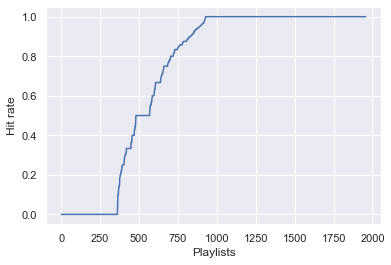

In [259]:
plt.xlabel("Playlists")
plt.ylabel("Hit rate")
plt.plot(sorted(hit_rates.values))
plt.show()

### Grid search

Grid search to find the optimal number of latent factors to compute when fitting model:

In [261]:
def grid_search_factors(srange, item_user_matrix, excl, playlist_to_indx,
                       parallelise=True):
    
    def helper(factors):
        model = implicit.als.AlternatingLeastSquares(factors=factors)

        # items_users matrix in this case is the songs_playlist matrix
        model.fit(item_user_matrix, show_progress=False)
        
        temp_hit_rates = calc_hit_rates(model, item_user_matrix, excl, playlist_to_indx,
                                        parallelise=False, progressbar=False)
    
        avg_hit_rate = np.mean([hr for _, hr in temp_hit_rates])
        
        print(f"factors {factors} | hit rate {avg_hit_rate}")
        
        return (factors, avg_hit_rate)
    
    iter_factors = tqdm(srange, total=len(srange))
    
    if parallelise:
        hit_rates = Parallel(n_jobs=4, prefer="threads")(delayed(helper)(factors) for factors in iter_factors)
    else:
        hit_rates = [helper(factors) for factors in iter_factors]
    
    return hit_rates

In [152]:
hit_rate_search = grid_search_factors(range(100, 700, 50), split_train_ratings_matrix, excl, playlist_to_indx,
                                     parallelise=True)

factors 100 | hit rate 0.7251190202175254
factors 150 | hit rate 0.7250090795170948
factors 200 | hit rate 0.7270362503327529
factors 250 | hit rate 0.7340325894489934
factors 300 | hit rate 0.7343500277525251

factors 350 | hit rate 0.73173063364382
factors 400 | hit rate 0.7299676653919273
factors 450 | hit rate 0.7274305244029073
factors 500 | hit rate 0.7242372050812332
factors 550 | hit rate 0.724471763389122
factors 600 | hit rate 0.7252985248652697
factors 650 | hit rate 0.721042535943308


In [155]:
pickle.dump(hit_rate_search, open("hit_rate_search.p", "wb"))

In [156]:
hit_rate_search

[(100, 0.7251190202175254),
 (150, 0.7250090795170948),
 (200, 0.7270362503327529),
 (250, 0.7340325894489934),
 (300, 0.7343500277525251),
 (350, 0.73173063364382),
 (400, 0.7299676653919273),
 (450, 0.7274305244029073),
 (500, 0.7242372050812332),
 (550, 0.724471763389122),
 (600, 0.7252985248652697),
 (650, 0.721042535943308)]

In [157]:
hit_rate_search = mf_utils.tuples_to_dict(hit_rate_search)

In [159]:
hit_rate_search = pd.Series(hit_rate_search)

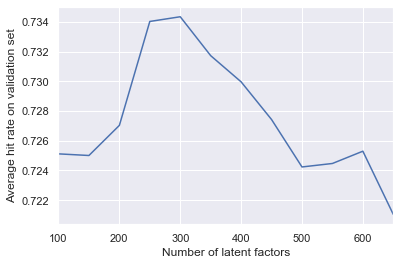

In [161]:
plt.xlabel("Number of latent factors")
plt.ylabel("Average hit rate on validation set")
hit_rate_search.plot()
plt.show()

From the above, it seems that 300 latent factors is approx. the optimal number of latent factors to compute.

The highest average hit rate which can be achieved is approx. 0.73. This is not as high as we would like, especially given that we are making 20,000 recommendations per playlist.

The goal now is to retain as much of this hit rate as possible while reducing the number of recommendations to a more reasonable number, e.g. 20.

## Hit rates for N recommendations

Loading data and models:

In [6]:
split_train_df = pd.read_csv("Split_Train_DF.csv", index_col=[0])
excl = pickle.load(open("Excluded_Songs_Series", "rb"))

split_train_ratings_matrix = mf_utils.df_to_sparse(split_train_df, all_songs=df.spotify_id.unique())

# Number of latent factors now 300
model = implicit.als.AlternatingLeastSquares(factors=300)

# items_users matrix in this case is the songs_playlist matrix
model.fit(split_train_ratings_matrix)

# CANNOT use songs_df here as order is different
indx_to_song = mf_utils.indx_mapping(df.spotify_id.unique())
indx_to_playlist = mf_utils.indx_mapping(split_train_df.playlist_id.unique())

song_to_indx = mf_utils.indx_mapping(df.spotify_id.unique(), indx_to_item=False)
playlist_to_indx = mf_utils.indx_mapping(split_train_df.playlist_id.unique(), indx_to_item=False)

In [18]:
reload(mf_utils)

<module 'mf_utils' from '../mf_utils.py'>

In [19]:
hit_rates = mf_utils.calc_hit_rates(model, split_train_ratings_matrix, excl, playlist_to_indx, indx_to_song,
                                    N=1000, parallelise=True)




 30%|██▉       | 578/1958 [00:16<00:11, 117.16it/s]

In [20]:
hit_rates = pd.Series(mf_utils.tuples_to_dict(hit_rates))

In [21]:
hit_rates.mean()

0.5965848042013409

We can see that we achieve a respectable 60% recall even when recommending only 1000 songs per playlist. This is a very good starting to point on which to build.

In [22]:
hit_rates = mf_utils.calc_hit_rates(model, split_train_ratings_matrix, excl, playlist_to_indx, indx_to_song,
                                    N=100, parallelise=True)

hit_rates = pd.Series(mf_utils.tuples_to_dict(hit_rates))

hit_rates.mean()

0.39853922570563916

In [25]:
hit_rates = mf_utils.calc_hit_rates(model, split_train_ratings_matrix, excl, playlist_to_indx, indx_to_song,
                                    N=10, parallelise=True)

hit_rates = pd.Series(mf_utils.tuples_to_dict(hit_rates))

hit_rates.mean()

0.11914176048925669

We can also see that even when we go to very low N (number of recommendations), we still a maintain a decent recall for approx. 10% despite there being over 500,000 songs in the dataset.

## Generating candidate songs for each playlist

In [16]:
split_train_df = pd.read_csv("Split_Train_DF.csv", index_col=[0])
# excl = pickle.load(open("Excluded_Songs_Series", "rb"))

# train_df.to_csv("Train_DF.csv")
# test_df.to_csv("Test_DF.csv")

In [17]:
split_train_ratings_matrix = mf_utils.df_to_sparse(split_train_df, all_songs=df.spotify_id.unique())

In [18]:
# Number of latent factors now 300
model = implicit.als.AlternatingLeastSquares(factors=300)

# items_users matrix in this case is the songs_playlist matrix
model.fit(split_train_ratings_matrix)

In [19]:
pickle.dump(model, open("WRMF_model_factors300.p", "wb"))

In [20]:
# CANNOT use songs_df here as order is different
indx_to_song = mf_utils.indx_mapping(df.spotify_id.unique())
indx_to_playlist = mf_utils.indx_mapping(split_train_df.playlist_id.unique())

song_to_indx = mf_utils.indx_mapping(df.spotify_id.unique(), indx_to_item=False)
playlist_to_indx = mf_utils.indx_mapping(split_train_df.playlist_id.unique(), indx_to_item=False)

In [21]:
def gen_wrmf_candidates(model, item_user_matrix, playlist_ids, playlist_to_indx, indx_to_song, N=20000):
    """
    Generates N recommendations for each playlist.
    
    Arguments:
        - model - pre-trained implicit model
        - item_user_matrix - sparse CSR item-user matrix
        - playlist_ids - list of unique playlist IDs to generate recommendations for
        - playlist_to_indx - dict. where key = playlist ID, value = index in matrix
        - indx_to_song - dict. where key = index in matrix, value = song Spotify ID
        - N - number of recommendations to generate per playlist
        
    Returns:
        - wrmf_recs_df - pandas DF containing recommended Spotify IDs. columns = playlist IDs
        - wrmf_score_df - pandas DF containing scores for above dataframe.
    """
    def helper(playlist_id):
        playlist_indx = playlist_to_indx[playlist_id]
        
#         Need to provide user-item matrix here
        recs = model.recommend(playlist_indx, item_user_matrix.T, N=N)
        rec_indxs, rec_scores = mf_utils.unpack_tuples_list(recs)
        
        rec_spot_ids = [indx_to_song[x] for x in rec_indxs]
        
        return (playlist_id, rec_spot_ids, rec_scores)

        
    play_ids, spot_ids, scores = mf_utils.unpack_tuples_list(
        Parallel(n_jobs=4, prefer="threads")(delayed(helper)(id_) for id_ in tqdm(playlist_ids)))
        
#     Quick check to ensure order was maintained in the above parallelised job
    assert (pd.Series(play_ids) == pd.Series(playlist_ids)).all()
        
    wrmf_recs_df = pd.DataFrame(columns=playlist_ids, data=np.asarray(spot_ids).T)
    wrmf_score_df = pd.DataFrame(columns=playlist_ids, data=np.asarray(scores).T)
    
    return wrmf_recs_df, wrmf_score_df

In [ ]:
wrmf_recs_df, wrmf_score_df = gen_wrmf_candidates(model, split_train_ratings_matrix,
                                                  split_train_df.playlist_id.unique(), playlist_to_indx, indx_to_song)

In [ ]:
wrmf_score_df

In [ ]:
wrmf_recs_df.to_csv("WRMF_Candidate_Spotify_IDs.csv")
wrmf_score_df.to_csv("WRMF_Candidate_Scores.csv")